In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import sys

Aim : Compare 'code 1' vs 'code 2' approaches to calculating Inter Quartile Range (IQR).  I need that because one of the things I need to calculate for the posterior PDF in calculating $\mu$, $\sigma$ using the AstroML 5.8 approach, is the median, which essentially requires a weighted IQR. 

## code 1 : weighted stats package 

In [121]:
# code for median : a bit more complex... Use that for now : 
#https://github.com/tinybike/weightedstats/blob/master/weightedstats/__init__.py
# https://pypi.python.org/pypi/weightedstats/0.2    
import weightedstats as ws

# usage  : 
#ws.numpy_weighted_median(data, weights)
# marginally faster (72 microseconds vs 80 microseconds  for a lightcurve of N=100 points)

    

In [127]:
# Try executing this code line by line, to find out what does it do...

# This is a pdf of a Gaussian. Thus by all means, we expect the mean and median to be 0. 
x = np.linspace(norm.ppf(0.01),
              norm.ppf(0.99), 100)
y = norm.pdf(x)

data = x
weights = y

ws.numpy_weighted_median(x,y)


0.0

In [6]:
result = %timeit -o ws.numpy_weighted_median(a,w)
t_msec = result.best*1000

10000 loops, best of 3: 72.4 µs per loop


In [8]:
result = %timeit -o ws.weighted_median(a,w)
t_msec = result.best*1000

10000 loops, best of 3: 80 µs per loop


## code 2 : weighted quantile 

In [70]:
def quantile_1D(data, weights, quantile):
    """
    Compute the weighted quantile of a 1D numpy array.
    Parameters
    ----------
    data : ndarray
        Input array (one dimension).
    weights : ndarray
        Array with the weights of the same size of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.
    Returns
    -------
    quantile_1D : float
        The output value.
    """
    # Check the data
    if not isinstance(data, np.matrix):
        data = np.asarray(data)
    if not isinstance(weights, np.matrix):
        weights = np.asarray(weights)
    nd = data.ndim
    if nd != 1:
        raise TypeError("data must be a one dimensional array")
    ndw = weights.ndim
    if ndw != 1:
        raise TypeError("weights must be a one dimensional array")
    if data.shape != weights.shape:
        raise TypeError("the length of data and weights must be the same")
    if ((quantile > 1.) or (quantile < 0.)):
        raise ValueError("quantile must have a value between 0. and 1.")
    # Sort the data
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    # Compute the auxiliary arrays
    Sn = np.cumsum(sorted_weights)
    # TODO: Check that the weights do not sum zero
    #assert Sn != 0, "The sum of the weights must not be zero"
    # -0.5*sorted_weights
    Pn = (Sn)/np.sum(sorted_weights)
    # Get the value of the weighted median
    return np.interp(quantile, Pn, sorted_data)

In [11]:
result = %timeit -o quantile_1D(a,w, 0.5)

The slowest run took 5.86 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 14.8 µs per loop


so it is faster than the ws.numpy_weighted_median code... Check whether they are consistent! 



In [52]:
iterations = 100000
code_1_median = np.zeros(iterations)
code_2_median = np.zeros(iterations)

for i in range(int(iterations)):
    # we draw 70 pts because that's how many points we have 
    # on a posterior PDF grid in AstroML 5.8 
    d = np.random.normal(loc=0.0, scale=1.0, size=70)
    w = np.ones_like(d)
    w = np.random.random(70)
    code_1_median[i] = ws.numpy_weighted_median(d,w)
    code_2_median[i] = quantile_1D(d,w,0.5)


In [89]:
np.mean(y)

0.20878593868819043

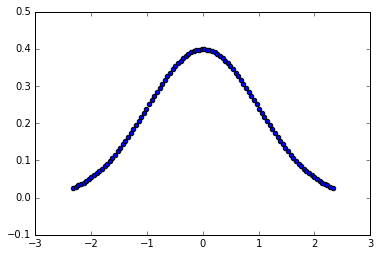

In [128]:
from scipy.stats import norm

x = np.linspace(norm.ppf(0.01),
              norm.ppf(0.99), 100)
fig,ax = plt.subplots()
ax.scatter(x, norm.pdf(x),label='norm pdf')

In [228]:
iterations = 10000
code_1_median = np.zeros(iterations)
code_2_median = np.zeros(iterations)


for i in range(int(iterations)):
    d = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
    w  = norm.pdf(x)
    code_1_median[i] = calcWeightedPercentile(d,w)
    #code_2_median[i] = quantile_1D(d,w,0.5)

In [229]:
code_1_median

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

## Conclusion

code 1 performs well , and I wouldn't worry about why code 2 doesn't do what I would expect. After all, there may be plenty of other codes, and I don't need to justify why I use one over the other.  In fact, I understand what the first one does, and it makes sense, so I just expand its functionality to calculate any percentile, not just median. 

In [6]:
def calcWeightedPercentile(data, weights=None, percentile = 50):
    """Calculate the weighted percentile of an array
    Given a vector V, a q-th percentile of V is the value q/100 
    of the way from minimum to maximum of the sorted array V.  
    With weights , we find the q/100 point of the sorted weights,
    and take that value of the data. 
    """
    import numpy as np
    # if there are actually no weights, then pass it on to regular percentile 
    if weights is None:
        return np.percentile(np.array(data).flatten(), percentile)
    data, weights = np.array(data).flatten(), np.array(weights).flatten()
    if any(weights > 0):
        # 1) sort the data and weights: 
        # first : zip(data,weights) gives a list of tuples: [(data1, weight1),(data2,weight2), ()....]
        # second: sorted sorts these according to data : 
        # example: data = [  2,   5,   1,   7,    3]  ,  
        #       weights = [0.1, 0.2, 0.3, 0.1, 0.05]
        # sorted(zip(data,weights))  yields [(1, 0.3), (2, 0.1), (3, 0.05), (5, 0.2), (7, 0.1)] 
        sorted_data, sorted_weights = map(np.array, zip(*sorted(zip(data, weights))))
        
        # 2) calculate the fraction to which we need to go. For median fraction=0.5
        fraction =  percentile / 100.0
        midpoint = fraction * sum(sorted_weights)
        
        # 3) check here if there is any weight that is way bigger than the rest, i.e. 
        # given the sum of sorted_weights, is there any weight that contributes more than the 
        # fraction point q/100 ? If there is , then q/100 will be on the datapoint corresponding to 
        # that weight  
        # example : data = [  2,   5,   1,   7,    3] ,  
        #         weights = [0.1, 10, 0.3, 0.2, 0.05])
        # for 50-th percentile, midpoint = 5.32 , so we see that the datapoint 5 has such a large weight 
        # that indeed any(weights > midpoint) == True ,  so that we want to return 
        # the datapoint with that huge weight . 
        # Note : It does not happen if there are two or more points 
        # in a dataset with large weight, so this if statement is only catching the case of one datapoint
        # with weightmuch greater than other points 
        if any(weights > midpoint):
            return (data[weights == np.max(weights)])[0]
        
        # 4) if there isn't any datapoint with exceedingly large weight, 
        # then calculate the cumulative sum of weights, and find out the 
        # datapoint corresponding to the position just below the midpoint 
        cumulative_weight = np.cumsum(sorted_weights)
        below_midpoint_index = np.where(cumulative_weight <= midpoint)[0][-1]
        
        # 5) if this is almost the same, then return that value 
        if cumulative_weight[below_midpoint_index] - midpoint < sys.float_info.epsilon:
            return np.mean(sorted_data[below_midpoint_index:below_midpoint_index+2])
        return sorted_data[below_midpoint_index+1]
    

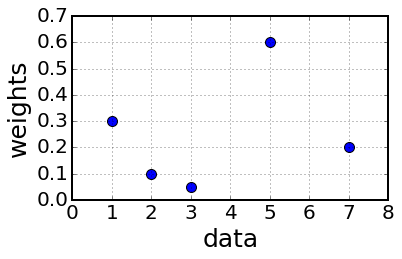

In [51]:
%matplotlib inline

from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['axes.labelsize'] = 25
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 20


data = [  2,   5,   1,   7,    3]
weights = [0.1, 0.6, 0.3, 0.2, 0.05]
data, weights = np.array(data).flatten(), np.array(weights).flatten()
sorted_data, sorted_weights = map(np.array, zip(*sorted(zip(data, weights))))

plt.scatter(data,weights, s=100)
plt.ylabel('weights')
plt.xlabel('data')
plt.grid()
plt.tight_layout()
plt.savefig('../data_products/01.25_IQR_illustrate_dataset.png')

In [44]:
sorted_data

array([1, 2, 3, 5, 7])

In [46]:
midpoint

0.625

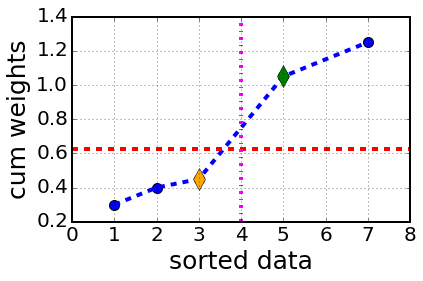

In [53]:
%matplotlib inline
data = [  2,   5,   1,   7,    3]
weights = [0.1, 0.6, 0.3, 0.2, 0.05]
data, weights = np.array(data).flatten(), np.array(weights).flatten()
sorted_data, sorted_weights = map(np.array, zip(*sorted(zip(data, weights))))

percentile = 50 
fraction =  percentile / 100.0
midpoint = fraction * sum(sorted_weights)

cumulative_weight = np.cumsum(sorted_weights)
below_midpoint_index = np.where(cumulative_weight <= midpoint)[0][-1]
        

plt.plot(sorted_data, cumulative_weight, ls='--', lw=4)
plt.scatter(sorted_data, cumulative_weight, s=100)
plt.plot(sorted_data[below_midpoint_index],cumulative_weight[below_midpoint_index], marker='d',
             c='orange', lw=0, markersize=15)
plt.axhline(midpoint, ls='--', color='red', lw=4)   
plt.plot(sorted_data[below_midpoint_index+1],cumulative_weight[below_midpoint_index+1], marker='d',
             c='green', lw=0, markersize=15)
plt.xlabel('sorted data')
plt.ylabel('cum weights')

if cumulative_weight[below_midpoint_index] - midpoint < sys.float_info.epsilon:
    median =  np.mean(sorted_data[below_midpoint_index:below_midpoint_index+2])
else:
    median  = sorted_data[below_midpoint_index+1]
    
plt.axvline(median, ls='-.', lw=4, c='magenta')
plt.grid()
plt.tight_layout()
plt.savefig('../data_products/01.25_IQR_illustrate.png')

Above is the illustration of that code : the horizontal red dashed line is the midpoint : $q / 100 * \sum{(sorted \, weights)}$.  The orange diamond marks the last point below midpoint : sorted_data[below_midpoint_index].   If the y value of the orange point is smaller than  the midpoint line, then we return the mean of orange and green points (magenta line). Otherwise, we return the x-value  of  the green point.  

Simulate  : a Gaussian PDF : median ought be 0. 

In [254]:
iterations = 10000
code_1_median = np.zeros(iterations)

for i in range(int(iterations)):
    d = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
    w  = norm.pdf(x)
    code_1_median[i] = calcWeightedPercentile(d,w)
   

In [9]:
pwd

'/Users/chris/GradResearch/SDSS_S82_FP_research/code'

Works well!   I conclude this as finished. I add this function to variabilityFunction.py package 

